In [94]:
from typing import Sequence, Callable
from collections import defaultdict
import operator
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from appknn import adf, create_aggregating_net, app_k_nearest, partition_data, mysample

In [101]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [2]:
def find_closest(net, app, distance, k=1):
    anchors = app_k_nearest(k=k, apps=net.keys(), new_app=app, distance=distance)
    new_list = []
    for a in anchors:
        if len(net[a])> 0:
            new_list+=net[a]
        new_list.append(a)       
    ns=app_k_nearest(k=1, apps=new_list, new_app=app, distance=distance)[0]
        
    return ns

In [3]:
def classify_app(appid, labels):
    return labels[labels.apn==appid]['malware_label'].values[0]


In [4]:
def votes_from_list(li, labels):
    classes = [int(classify_app(a, labels)) for a in li]
    su = sum(classes)
    return len(classes)-su, su

def convert_to_voting(net, labels):
    voting_network = defaultdict(lambda: [0, 0])

    for k, l in net.items():
        bi, mal = votes_from_list(l+[k], labels)
        voting_network[k]=[bi, mal]
        
    return voting_network

In [42]:
def merge_voting_nets(nets, distance, gamma):
    apns = []
    for net in nets:
        apns+=list(net.keys())
        
    nn = create_aggregating_net(gamma=gamma,
                                apns=apns, 
                                distance=distance)
    targ = defaultdict(lambda: [0, 0])

    for k,v in nn.items():
        for net in nets:
            targ[k] = [i+j for i,j in zip(targ[k], net.get(k, [0, 0]))]
            
        for el in v:
            for net in nets:
                targ[k] = [i+j for i,j in zip(targ[k], net.get(el, [0, 0]))]
            #targ[k] = [i+j for i,j in zip(targ[k], convert_to_voting([el], labels))]
    
    return targ

In [97]:
v = pd.read_csv('data/functions_encoded.csv')
funcs = v.groupby(by='apn')['nf'].apply(set)

In [7]:
labels = pd.read_csv('data/labels_encoded.csv')

In [15]:
sample_size = 200
smp = mysample(v, sample_size)
funcs_smp = smp.groupby(by='apn')['nf'].apply(set)

distance=lambda x,y: adf(x,y, funcs_smp)

In [13]:
gamma =4
n_parts = 2

In [24]:
reference_netw = create_aggregating_net(gamma=gamma, apns=smp.apn.unique(), distance=lambda x,y: adf(x,y, funcs_smp))
reference_voting = convert_to_voting(reference_netw, labels)

In [16]:
partitions = partition_data(smp.apn.unique(), n_parts)

In [39]:
def count_elements(net):
    return sum(map( lambda x: x[0]+x[1], net.values()))

In [79]:
def classify_using_voting(app, net, distance, k=1):
    ns = app_k_nearest(k=k, apps=net.keys(), new_app=app, distance=distance)

    ret = [0, 0]
    for n in ns:
        ret = np.add(ret, net[n])
    return ret

In [95]:
def evaluate_voting_net(apns, net, k=3):
    fp = 0
    fn = 0
    for a in apns:
        v1 = classify_using_voting(app=a, net=net, distance=lambda x,y: adf(x,y, funcs), k=k)

        gt = classify_app(a, labels)
        rt = v1[0] < v1[1]
        if gt!=rt:
            if rt==True:
                fp+=1
            else:
                fn+=1
                
    return fn, fp

In [98]:
apns = np.random.choice(v.apn.unique(), size=50, replace=False)

In [ ]:
n_parts = 4
partitions = partition_data(smp.apn.unique(), n_parts)

In [103]:
res = dict()
res_ref = dict()
nets = dict()

for gamma in tqdm([0, 1, 2, 4, 8, 16]):
    networks = [create_aggregating_net(gamma=gamma, apns=part, distance=distance) for part in partitions]
    voting_networks = [convert_to_voting(net, labels) for net in networks]
    mv = merge_voting_nets(nets=voting_networks, distance=distance, gamma=gamma)
    
    reference_netw = create_aggregating_net(gamma=gamma, apns=smp.apn.unique(), distance=lambda x,y: adf(x,y, funcs_smp))
    reference_voting = convert_to_voting(reference_netw, labels)
    
    #save the net
    nets[gamma] = [mv.copy(), reference_voting.copy()]
    false_negative, false_positives = evaluate_voting_net(apns=apns, net=mv)
    res[gamma] = [false_negative, false_positives]
    
    false_negative, false_positives = evaluate_voting_net(apns=apns, net=reference_voting)
    res_ref[gamma] = [false_negative, false_positives]
    

In [110]:
merged = pd.DataFrame.from_dict(res, orient='index', columns=['fPos', 'fNeg'])
reference = pd.DataFrame.from_dict(res_ref, orient='index', columns=['fPos', 'fNeg'])


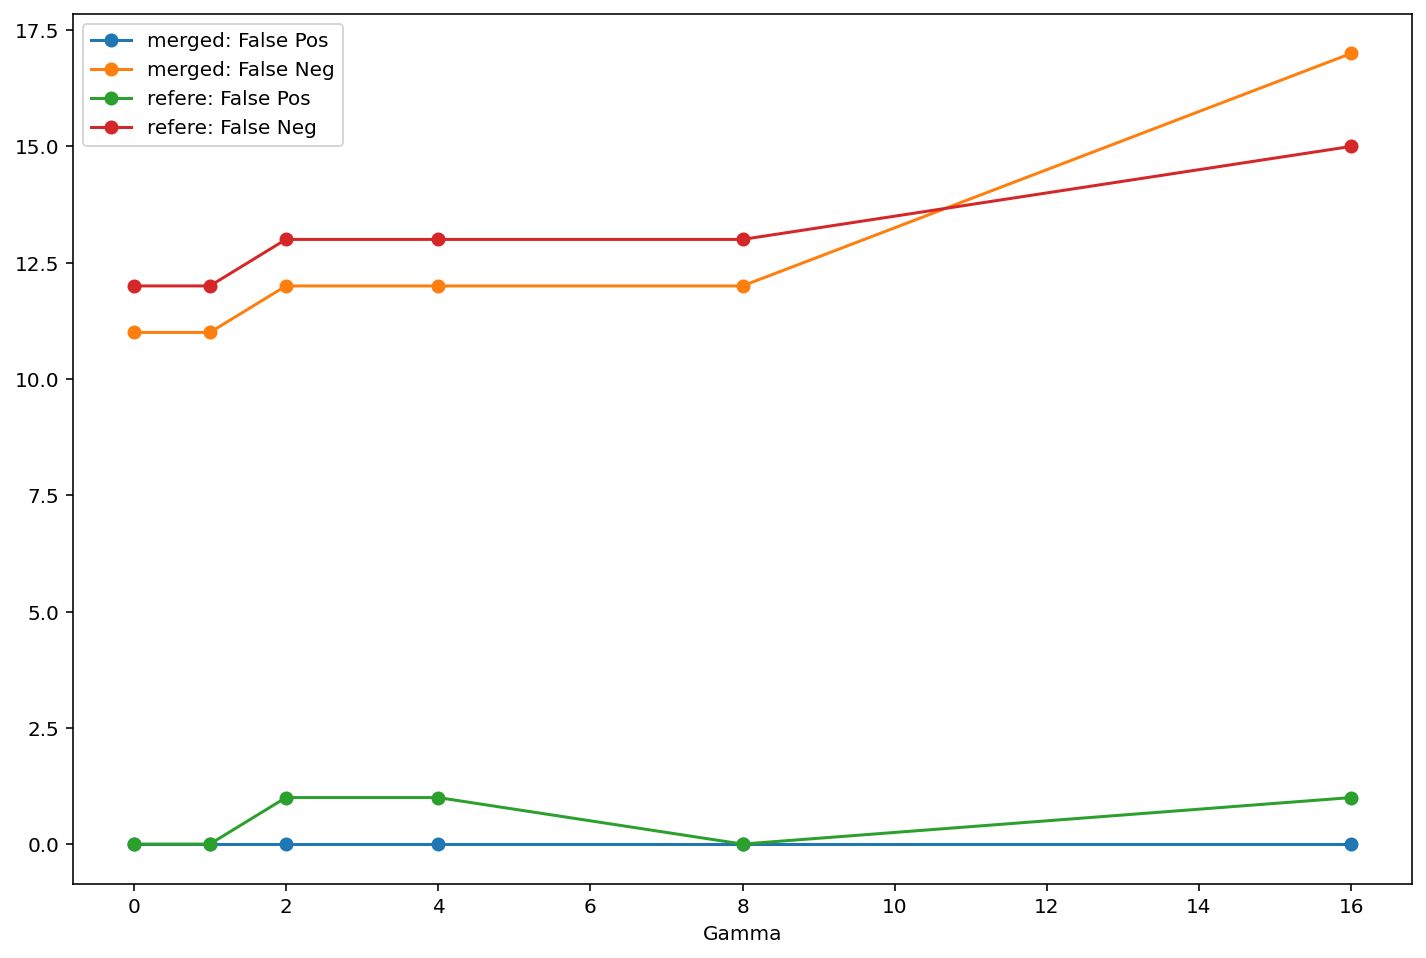

In [120]:
plt.figure(figsize=(12, 8))
plt.plot(merged.fPos,'o-', label='merged: False Pos')
plt.plot(merged.fNeg,'o-', label='merged: False Neg')

plt.plot(reference.fPos,'o-', label='refere: False Pos')
plt.plot(reference.fNeg,'o-', label='refere: False Neg')


plt.xlabel('Gamma');
plt.legend()